<a href="https://colab.research.google.com/github/geo-tp/Keras-Colaboratory-Models/blob/main/bug_path_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bug Path Recurent Neural Network - Predict future path of a bug

## Import

In [111]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
from math import sin,cos,pi
import matplotlib.pyplot as plt

## Parameters

In [112]:
# ---- About dataset
#
max_t        = 1000
delta_t      = 0.02
features_len = 2


sequence_len = 50
predict_len  = 5

# ---- About training
#
scale         = .2       # Percentage of dataset to be used (1=all)
train_prop    = .8       # Percentage for train (the rest being for the test)
batch_size    = 32
epochs        = 15
fit_verbosity = 1        # 0 = silent, 1 = progress bar, 2 = one line per epoch

## Dataset

In [132]:
# Generating x, y values representing a bug path


def ladybug_init(s=122):
    
    if s>0 : random.seed(s)
    ladybug_init.params_x = [ random.gauss(0.,1.) for u in range(8)]
    ladybug_init.params_y = [ random.gauss(0.,1.) for u in range(8)]
    
def ladybug_move(t):
    k=0.5
    [ax1, ax2, ax3, ax4, kx1, kx2, kx3, kx4] = ladybug_init.params_x
    [ay1, ay2, ay3, ay4, ky1, ky2, ky3, ky4] = ladybug_init.params_y
    
    x = ax1*sin(t*(kx1+20)) + ax2*cos(t*(kx2+10)) + ax3*sin(t*(kx3+5)) + ax4*cos(t*(kx4+5))
    y = ay1*cos(t*(ky1+20)) + ay2*sin(t*(ky2+10)) + ay3*cos(t*(ky3+5)) + ay4*sin(t*(ky4+5)) 

    return x,y


# ---- Get positions
#
ladybug_init(s=16)
x,y = 0,0
positions=[]
for t in np.arange(0., max_t, delta_t):
    x,y = ladybug_move(t)
    positions.append([x,y])

# ---- Build rescaled dataset
#
n = int( len(positions)*scale )
dataset = np.array(positions[:n])

k = int(len(dataset)*train_prop)
x_train = dataset[:k]
x_test  = dataset[k:]

# ---- Normalize
#
mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

print("Dataset generated.")
print("Train shape is : ", x_train.shape)
print("Test  shape is : ", x_test.shape)
print("Example from dataset : \n", x_train[0: 10])

Dataset generated.
Train shape is :  (8000, 2)
Test  shape is :  (2000, 2)
Example from dataset : 
 [[ 1.50975485  0.6010695 ]
 [ 1.09633697  0.56857257]
 [ 0.67234528  0.40867497]
 [ 0.27646604  0.15263039]
 [-0.06105697 -0.1527544 ]
 [-0.32202155 -0.45254989]
 [-0.5020269  -0.69241426]
 [-0.610179   -0.82721223]
 [-0.66681805 -0.82818486]
 [-0.69962406 -0.68754121]]


In [115]:
# Timeseries Generators

train_generator = TimeseriesGenerator(x_train, x_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(x_test,  x_test,  length=sequence_len,  batch_size=batch_size)

## Model

In [116]:
# Model definition - This model should predict the path of a flying bug

model = keras.models.Sequential()
model.add( keras.layers.InputLayer(input_shape=(sequence_len, features_len)) )
model.add( keras.layers.GRU(200, return_sequences=False, activation='relu') )
#model.add( keras.layers.LSTM(200, return_sequences=False, activation='relu') )
model.add( keras.layers.Dense(features_len) )

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 200)               122400    
                                                                 
 dense_3 (Dense)             (None, 2)                 402       
                                                                 
Total params: 122,802
Trainable params: 122,802
Non-trainable params: 0
_________________________________________________________________


## Training

In [118]:
model.compile(optimizer='rmsprop', 
              loss='mse', 
              metrics   = ['mae'] )

history=model.fit(train_generator, 
                  epochs  = epochs, 
                  verbose = fit_verbosity,
                  validation_data = test_generator)

Epoch 1/15
249/249 [==============================] - 30s 110ms/step - loss: 0.1455 - mae: 0.2770 - val_loss: 0.0188 - val_mae: 0.1116
Epoch 2/15
249/249 [==============================] - 26s 106ms/step - loss: 0.0159 - mae: 0.1003 - val_loss: 0.0097 - val_mae: 0.0795
Epoch 3/15
249/249 [==============================] - 28s 111ms/step - loss: 0.0082 - mae: 0.0721 - val_loss: 0.0127 - val_mae: 0.0925
Epoch 4/15
249/249 [==============================] - 29s 116ms/step - loss: 0.0051 - mae: 0.0570 - val_loss: 0.0034 - val_mae: 0.0472
Epoch 5/15
249/249 [==============================] - 27s 108ms/step - loss: 0.0036 - mae: 0.0463 - val_loss: 0.0015 - val_mae: 0.0299
Epoch 6/15
249/249 [==============================] - 28s 114ms/step - loss: 0.0028 - mae: 0.0412 - val_loss: 0.0022 - val_mae: 0.0383
Epoch 7/15
249/249 [==============================] - 31s 126ms/step - loss: 0.0023 - mae: 0.0375 - val_loss: 0.0020 - val_mae: 0.0341
Epoch 8/15
249/249 [==============================] - 3

## Results

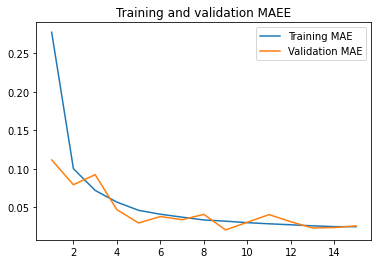

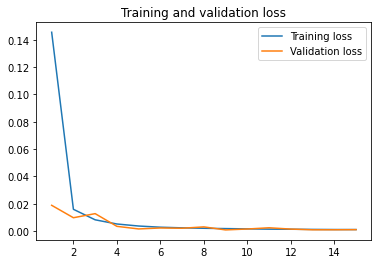

In [119]:
# Showing MAE and Loss results

mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, label='Training MAE')
plt.plot(epochs, val_mae, label='Validation MAE')
plt.title('Training and validation MAEE')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [129]:
# Evaluate to get max average error and loss on test set

loss, mae = model.evaluate(test_generator)
print("MAE :", mae, " LOSS :", loss)

61/61 [==============================] - 2s 29ms/step - loss: 9.7739e-04 - mae: 0.0261
MAE : 0.026149634271860123  LOSS : 0.0009773938218131661


## Prediction

In [121]:
# Visualize sequence path

def plot_2d_segment(sequence_true, sequence_pred, ms=6, lw=1):

  k = len(sequence_pred)
  x,y = sequence_true[:,0],sequence_true[:,1]
  u,v = sequence_pred[:,0],sequence_pred[:,1]

  fig = plt.figure(figsize=(10,8))
  ax = plt.axes()

  # ---- Draw real sequence without prediction
  #
  ax.plot(x[:-k], y[:-k],   'o', color='C0', fillstyle='full', zorder=2, ms=ms)
  ax.plot(x, y,             '-', color='C0', lw=lw, zorder=1)

  # ---- What we expect
  #
  ax.plot(x[-k:], y[-k:], 'o', ms=ms, markeredgecolor='C0', markerfacecolor='white', zorder=2)

  # ---- What we have
  #
  ax.plot(u, v,                            'o',  color='C1',fillstyle='full',zorder=2, ms=ms)
  ax.plot( [x[-1-k],u[0]], [y[-1-k],v[0]], '--', color='C1',lw=lw, zorder=1)
  ax.plot(u, v,                            '--', color='C1',lw=lw, zorder=1)

  ax.set_aspect('equal', 'box')
  ax.set_xlabel('axis=0')
  ax.set_ylabel('axis=1')

  ax.set_yticks([])
  ax.set_xticks([])

  plt.show()

1/1 [==============================] - 0s 183ms/step


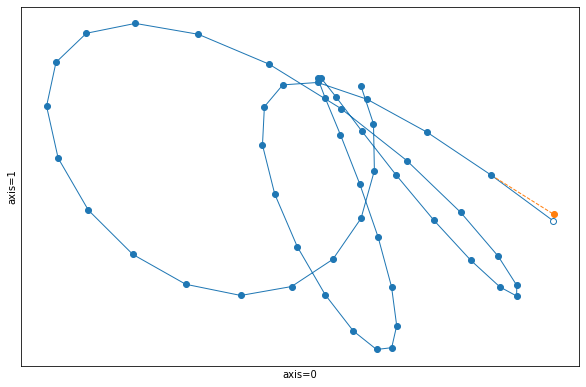

In [122]:
# Comparing a prediction to its real value

s = random.randint(0, len(x_test)-sequence_len)

sequence = x_test[s:s+sequence_len]
sequence_true = x_test[s:s+sequence_len+1]

sequence_pred = model.predict(np.array([sequence]))

plot_2d_segment(sequence_true, sequence_pred)

In [123]:
# Chaining predictions to get more future sequences

def get_prediction(dataset, model, iterations=4):

    # ---- Initial sequence
    #
    s=random.randint(0,len(dataset)-sequence_len-iterations)

    sequence_pred = dataset[s:s+sequence_len].copy()
    sequence_true = dataset[s:s+sequence_len+iterations].copy()

    # ---- Iterate 
    #
    sequence_pred = list(sequence_pred)

    for i in range(iterations):
        sequence   = sequence_pred[-sequence_len:]
        prediction = model.predict( np.array([sequence]) )
        sequence_pred.append(prediction[0])

    # ---- Extract the predictions    
    #
    prediction = np.array(sequence_pred[-iterations:])

    return sequence_true , prediction

1/1 [==============================] - 0s 32ms/step


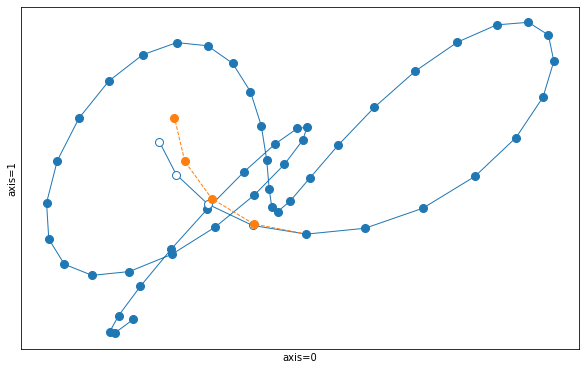

In [128]:
# Comparing 4 predicted sequences to its real sequences

sequence_true, sequence_pred = get_prediction(x_test, model)

plot_2d_segment(sequence_true, sequence_pred, ms=8)